In [22]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, peak_prominences

In [23]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


In [24]:
###### ACC
# 가속도 벡터 magnitude 계산 함수
def calculate_speed(acc_x, acc_y, acc_z):
    speed_mag = (acc_x ** 2 + acc_y ** 2 + acc_z ** 2) ** 0.5
    return speed_mag

###### EDA
# rolling window에서 피크를 찾는 함수
def find_peaks_in_rolling_window(data, window_size):
    number_of_windows = 0
    peaks_in_window = 0
    for window_data in data.rolling(window=window_size):
        peaks, _ = find_peaks(window_data[' eda'], height=0, distance=4, prominence=0.3)
        if peaks.any():
            peaks_in_window += len(peaks)
        number_of_windows += 1
    return number_of_windows, peaks_in_window

In [25]:
# 빈 DataFrame 생성
df = pd.DataFrame(columns=[
    'calories2hr',
    'protein2hr',
    'sugar2hr',
    'carbs2hr',
    'calories8hr',
    'protein8hr',
    'sugar8hr',
    'carbs8hr',
    'calories24hr',
    'protein24hr',
    'sugar24hr',
    'carbs24hr',
    'acc_mean',
    'acc_std',
    'acc_min',
    'acc_max',
    'acc_q1g',
    'acc_q3g',
    'acc_skew',
    'eda_mean',
    'eda_std',
    'eda_min',
    'eda_max',
    'eda_q1g',
    'eda_q3g',
    'eda_skew',
    'PeakEDA',
    'PeakEDA2hr_sum',
    'PeakEDA2hr_mean',
    'hr_mean',
    'hr_std',
    'hr_min',
    'hr_max',
    'hr_q1g',
    'hr_q3g',
    'hr_skew',
    'maxHRV',
    'minHRV',
    'medianHRV',
    'meanHRV',
    'SDNN',
    'NN50',
    'pNN50',
    'RMSSD',
    'temp_mean',
    'temp_std',
    'temp_min',
    'temp_max',
    'temp_q1g',
    'temp_q3g',
    'temp_skew'
])

## Warnings

* 003 데이터셋 Food_Log에 칼럼 누락되어 있음 추가 필요 (단, time_end 칼럼은 없어야 하며, 뒷부분의 4개 칼럼은 {calorie,total_carb,sugar,protein}으로 구성됨).
* 001 데이터셋의 HR 대해서 datetime 포맷이 다름 (hr_df['datetime']=pd.to_datetime(hr_df['datetime'], format='%m/%d/%y %H:%M')).
* 012 데이터셋 Food_Log의 마지막 행에 데이터 누락됨.
    ~~~
    2020-05-11,07:00:00,,,Boost,,,,654.0,82.0,5.6,40.0,26.0,26.0
    -> 2020-05-11,07:00:00, 2020-05-11 07:00:00,,Boost,,,,654.0,82.0,5.6,40.0,26.0,26.0
    ~~~
* 013 데이터셋 Food_Log의 date와 datetime 포맷이 다름.

In [26]:
for id in range(1, len(dg_df)+1):
    fl_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/Food_Log_{id:03}.csv')
    acc_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/ACC_{id:03}.csv')
    eda_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/EDA_{id:03}.csv')
    bvp_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/BVP_{id:03}.csv')
    hr_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/HR_{id:03}.csv')
    ibi_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/IBI_{id:03}.csv')
    temp_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/TEMP_{id:03}.csv')
    dexcom_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/Dexcom_{id:03}.csv')

    biological_sex = dg_df.loc[dg_df['ID'] == id, 'Gender'].values[0]
    hbA1c = dg_df.loc[dg_df['ID'] == id, 'HbA1c'].values[0]

    target = 0

    if hbA1c > 5.6:
        target = 1

    print(f'ID : {id} | target : {target}')
    

    ###### food log
    
    #if id == 13:
    #    fl_df['date']=pd.to_datetime(fl_df['date'], format='%m/%d/%y')
    #else:
    #    fl_df['date']=pd.to_datetime(fl_df['date'])
        
    if id == 13:
        fl_df['time_begin']=pd.to_datetime(fl_df['time_begin'], format='%m/%d/%Y %H:%M')
    else:
        fl_df['time_begin']=pd.to_datetime(fl_df['time_begin'])
    fl_df.index = pd.DatetimeIndex(fl_df["time_begin"])
    fl_df = fl_df.sort_index()

    calories2hr = 0.
    protein2hr = 0.
    sugar2hr = 0.
    carbs2hr = 0.
    calories8hr = 0.
    protein8hr = 0.
    sugar8hr = 0.
    carbs8hr = 0.
    calories24hr = 0.
    protein24hr = 0.
    sugar24hr = 0.
    carbs24hr = 0.

    for window_data in fl_df.rolling(window='2h', on='time_begin'):
        calories2hr += window_data['calorie'].values.sum()
        protein2hr += window_data['protein'].values.sum()
        sugar2hr += window_data['sugar'].values.sum()
        carbs2hr += window_data['total_carb'].values.sum()

    for window_data in fl_df.rolling(window='8h', on='time_begin'):
        calories8hr += window_data['calorie'].values.sum()
        protein8hr += window_data['protein'].values.sum()
        sugar8hr += window_data['sugar'].values.sum()
        carbs8hr += window_data['total_carb'].values.sum()

    for window_data in fl_df.rolling(window='24h', on='time_begin'):
        calories24hr += window_data['calorie'].values.sum()
        protein24hr += window_data['protein'].values.sum()
        sugar24hr += window_data['sugar'].values.sum()
        carbs24hr += window_data['total_carb'].values.sum()


    ###### accelerometer

    acc_df['datetime']=pd.to_datetime(acc_df['datetime'])
    acc_df['vector_mag'] = calculate_speed(acc_df[' acc_x'], acc_df[' acc_y'], acc_df[' acc_z'])
    acc_resampled = acc_df.set_index('datetime').resample('5Min').first()

    acc_mean = acc_resampled['vector_mag'].mean()
    acc_std = acc_resampled['vector_mag'].std()
    acc_min = acc_resampled['vector_mag'].min()
    acc_max = acc_resampled['vector_mag'].max()
    acc_q1g = acc_resampled['vector_mag'].quantile(0.25)
    acc_q3g = acc_resampled['vector_mag'].quantile(0.75)
    acc_skew = acc_resampled['vector_mag'].skew()


    ###### eda

    eda_df['datetime']=pd.to_datetime(eda_df['datetime'])
    eda_resampled = eda_df.set_index('datetime').resample('5Min').first()

    eda_mean = eda_resampled[' eda'].mean()
    eda_std = eda_resampled[' eda'].std()
    eda_min = eda_resampled[' eda'].min()
    eda_max = eda_resampled[' eda'].max()
    eda_q1g = eda_resampled[' eda'].quantile(0.25)
    eda_q3g = eda_resampled[' eda'].quantile(0.75)
    eda_skew = eda_resampled[' eda'].skew()

    # peak detection
    peaks_idx, properties = find_peaks(eda_resampled[' eda'], height=0, distance=4, prominence=0.3)
    peak_eda = len(peaks_idx)

    number_of_windows, peaks_in_window = find_peaks_in_rolling_window(eda_resampled, window_size='2h')
    peakEDA2hr_sum = peaks_in_window
    peakEDA2hr_mean = peaks_in_window / number_of_windows


    ###### hr

    if id == 1:
        hr_df['datetime']=pd.to_datetime(hr_df['datetime'], format='%m/%d/%y %H:%M')
    else:
        hr_df['datetime']=pd.to_datetime(hr_df['datetime'])
    hr_resampled = hr_df.set_index('datetime').resample('5Min').first()

    hr_mean = hr_resampled[' hr'].mean()
    hr_std = hr_resampled[' hr'].std()
    hr_min = hr_resampled[' hr'].min()
    hr_max = hr_resampled[' hr'].max()
    hr_q1g = hr_resampled[' hr'].quantile(0.25)
    hr_q3g = hr_resampled[' hr'].quantile(0.75)
    hr_skew = hr_resampled[' hr'].skew()


    ###### ibi

    ibi_df['datetime']=pd.to_datetime(ibi_df['datetime'])
    ibi_resampled = ibi_df.set_index('datetime').resample('5Min').first().interpolate(method='time')
    ibi_resampled[' ibi'] = ibi_resampled[' ibi'] * 1000 # 초 -> 밀리초 단위로

    maxHRV = ibi_resampled[' ibi'].max()
    minHRV = ibi_resampled[' ibi'].min()
    medianHRV = ibi_resampled[' ibi'].median()
    meanHRV = ibi_resampled[' ibi'].mean()
    sdnn = ibi_resampled[' ibi'].std()

    nn50 = 0.
    for i in range(len(ibi_resampled)-1):
        if np.abs(ibi_resampled.iloc[i+1][' ibi'] - ibi_resampled.iloc[i][' ibi']) > 50:
            nn50 +=1

    pnn50 = nn50/len(ibi_resampled)

    rmssd = 0.
    for i in range(len(ibi_resampled)-1):
        rmssd = np.abs(ibi_resampled.iloc[i+1][' ibi'] - ibi_resampled.iloc[i][' ibi'])**2
    rmssd = np.sqrt(rmssd) / len(ibi_resampled)


    ###### temp

    temp_df['datetime']=pd.to_datetime(temp_df['datetime'])
    temp_resampled = temp_df.set_index('datetime').resample('5Min').first()

    temp_mean = temp_resampled[' temp'].mean()
    temp_std = temp_resampled[' temp'].std()
    temp_min = temp_resampled[' temp'].min()
    temp_max = temp_resampled[' temp'].max()
    temp_q1g = temp_resampled[' temp'].quantile(0.25)
    temp_q3g = temp_resampled[' temp'].quantile(0.75)
    temp_skew = temp_resampled[' temp'].skew()


    ## results
    print('##################################')
    print(f'calories2hr : {calories2hr}')
    print(f'protein2hr : {protein2hr}')
    print(f'sugar2hr : {sugar2hr}')
    print(f'carbs2hr : {carbs2hr}')

    print(f'calories8hr : {calories8hr}')
    print(f'protein8hr : {protein8hr}')
    print(f'sugar8hr : {sugar8hr}')
    print(f'carbs8hr : {carbs8hr}')

    print(f'calories24hr : {calories24hr}')
    print(f'protein24hr : {protein24hr}')
    print(f'sugar24hr : {sugar24hr}')
    print(f'carbs24hr : {carbs24hr}')

    print(f'acc_mean : {acc_mean}')
    print(f'acc_std : {acc_std}')
    print(f'acc_min : {acc_min}')
    print(f'acc_max : {acc_max}')
    print(f'acc_q1g : {acc_q1g}')
    print(f'acc_q3g : {acc_q3g}')
    print(f'acc_skew : {acc_skew}')

    print(f'eda_mean : {eda_mean}')
    print(f'eda_std : {eda_std}')
    print(f'eda_min : {eda_min}')
    print(f'eda_max : {eda_max}')
    print(f'eda_q1g : {eda_q1g}')
    print(f'eda_q3g : {eda_q3g}')
    print(f'eda_skew : {eda_skew}')
    print(f'PeakEDA : {peak_eda}')
    print(f'PeakEDA2hr_sum : {peakEDA2hr_sum}')
    print(f'PeakEDA2hr_mean : {peakEDA2hr_mean}')

    print(f'hr_mean : {hr_mean}')
    print(f'hr_std : {hr_std}')
    print(f'hr_min : {hr_min}')
    print(f'hr_max : {hr_max}')
    print(f'hr_q1g : {hr_q1g}')
    print(f'hr_q3g : {hr_q3g}')
    print(f'hr_skew : {hr_skew}')

    print(f'maxHRV : {maxHRV}')
    print(f'minHRV : {minHRV}')
    print(f'medianHRV : {medianHRV}')
    print(f'meanHRV : {meanHRV}')
    print(f'SDNN : {sdnn}')
    print(f'NN50 : {nn50}')
    print(f'pNN50 : {pnn50}')
    print(f'RMSSD : {rmssd}')

    print(f'temp_mean : {temp_mean}')
    print(f'temp_std : {temp_std}')
    print(f'temp_min : {temp_min}')
    print(f'temp_max : {temp_max}')
    print(f'temp_q1g : {temp_q1g}')
    print(f'temp_q3g : {temp_q3g}')
    print(f'temp_skew : {temp_skew}')
    print('##################################')

    new_record = {
        'ID': id,
        'HbA1c': hbA1c,
        'calories2hr': calories2hr,
        'protein2hr': protein2hr,
        'sugar2hr': sugar2hr,
        'carbs2hr': carbs2hr,
        'calories8hr': calories8hr,
        'protein8hr': protein8hr,
        'sugar8hr': sugar8hr,
        'carbs8hr': carbs8hr,
        'calories24hr': calories24hr,
        'protein24hr': protein24hr,
        'sugar24hr': sugar24hr,
        'carbs24hr': carbs24hr,
        'acc_mean': acc_mean,
        'acc_std': acc_std,
        'acc_min': acc_min,
        'acc_max': acc_max,
        'acc_q1g': acc_q1g,
        'acc_q3g': acc_q3g,
        'acc_skew': acc_skew,
        'eda_mean': eda_mean,
        'eda_std': eda_std,
        'eda_min': eda_min,
        'eda_max': eda_max,
        'eda_q1g': eda_q1g,
        'eda_q3g': eda_q3g,
        'eda_skew': eda_skew,
        'PeakEDA': peak_eda,
        'PeakEDA2hr_sum': peakEDA2hr_sum,
        'PeakEDA2hr_mean': peakEDA2hr_mean,
        'hr_mean': hr_mean,
        'hr_std': hr_std,
        'hr_min': hr_min,
        'hr_max': hr_max,
        'hr_q1g': hr_q1g,
        'hr_q3g': hr_q3g,
        'hr_skew': hr_skew,
        'maxHRV': maxHRV,
        'minHRV': minHRV,
        'medianHRV': medianHRV,
        'meanHRV': meanHRV,
        'SDNN': sdnn,
        'NN50': nn50,
        'pNN50': pnn50,
        'RMSSD': rmssd,
        'temp_mean': temp_mean,
        'temp_std': temp_std,
        'temp_min': temp_min,
        'temp_max': temp_max,
        'temp_q1g': temp_q1g,
        'temp_q3g': temp_q3g,
        'temp_skew': temp_skew
    }

    df = pd.concat([df, pd.DataFrame([new_record])], ignore_index=True)
    

ID : 1 | target : 0
##################################
calories2hr : 20893.600000000002
protein2hr : 1011.3000000000001
sugar2hr : 1240.8
carbs2hr : 2487.5999999999995
calories8hr : 38917.3
protein8hr : 1606.2
sugar8hr : 2642.400000000001
carbs8hr : 4957.200000000001
calories24hr : 92074.59999999998
protein24hr : 4206.999999999997
sugar24hr : 6144.199999999998
carbs24hr : 11382.299999999994
acc_mean : 64.01035563170277
acc_std : 5.315251848206103
acc_min : 28.035691537752374
acc_max : 111.61989070053778
acc_q1g : 62.76145313805282
acc_q3g : 64.77653896280658
acc_skew : 1.9510091083168808
eda_mean : 0.9408512084705883
eda_std : 1.9022207772357134
eda_min : 0.0
eda_max : 27.837559
eda_q1g : 0.135797
eda_q3g : 0.802353
eda_skew : 4.832521811562482
PeakEDA : 176
PeakEDA2hr_sum : 3872
PeakEDA2hr_mean : 1.4761723217689668
hr_mean : 73.44717043314502
hr_std : 16.438131272262012
hr_min : 47.57
hr_max : 176.35
hr_q1g : 60.73
hr_q3g : 81.69
hr_skew : 1.3140585318470634
maxHRV : 1625.073999999999

In [40]:
df.head(16)

,calories2hr,protein2hr,sugar2hr,carbs2hr,calories8hr,protein8hr,sugar8hr,carbs8hr,calories24hr,protein24hr,...,pNN50,RMSSD,temp_mean,temp_std,temp_min,temp_max,temp_q1g,temp_q3g,temp_skew,ID
0,20893.6,1011.3,1240.8,2487.6,38917.3,1606.2,2642.4,4957.2,92074.6,4207.0,...,0.536436,0.005962,33.254033,2.679598,18.51,36.71,30.89,35.7100,-0.661237,1.0
1,30536.9,1152.8,1999.3,3727.7,58514.2,2022.8,4604.4,7995.6,136261.3,4499.2,...,0.452218,0.046664,34.150791,1.358199,22.47,36.68,33.83,34.8300,-3.479427,2.0
2,28444.7,1595.9,851.6,2657.3,42310.1,2594.1,1418.9,4389.9,107327.7,6024.8,...,0.328539,0.049160,33.303376,2.468538,20.77,36.79,32.49,34.8850,-2.339444,3.0
3,23178.4,1682.9,670.2,1943.8,41807.8,2709.1,1442.2,4328.2,87817.6,5652.6,...,0.388296,0.026699,34.342147,1.426525,23.31,36.47,33.68,35.3100,-3.183764,4.0
4,28783.1,1230.3,1045.4,2779.4,62054.2,2699.6,2086.4,5600.7,152590.8,5961.7,...,0.534389,0.009057,33.244554,1.637403,21.93,36.16,32.66,34.1300,-3.807010,5.0
5,41281.0,1659.2,2158.3,5844.4,71103.0,3171.5,3666.5,9864.5,174527.0,7399.8,...,0.370564,0.076117,33.321988,1.556857,24.57,37.29,32.58,34.4100,-0.913997,6.0
6,31319.8,1644.0,868.8,4114.2,71044.7,3379.7,2538.7,9026.0,149317.6,6999.1,...,0.523995,0.020267,32.972494,2.397617,22.21,36.27,31.63,34.9100,-1.516033,7.0
7,42077.0,1901.9,1334.4,4503.9,71307.4,2909.9,2986.0,8437.4,154976.9,6267.5,...,0.475048,0.012089,33.082605,2.068693,19.29,36.43,31.53,34.8700,-1.004582,8.0
8,27220.0,1258.6,1008.2,2412.4,54450.7,2199.9,2716.6,5587.8,133763.7,5652.4,...,0.389794,0.013401,33.577339,1.818956,22.99,36.75,32.65,34.8400,-1.828500,9.0
9,65653.8,4657.7,2189.4,5967.7,179890.9,12274.1,6310.9,15501.1,425338.0,28179.7,...,0.519616,0.027246,33.431243,2.341186,20.53,35.93,32.81,35.0000,-2.514667,10.0


In [49]:
df.to_csv(r'./features.csv', sep='\t', encoding='utf-8', header='true')

In [51]:
from sklearn.ensemble import RandomForestClassifier

def calculate_feature_importance(dataframe):
    # 데이터셋을 피쳐와 타겟으로 나누기
    X = dataframe.drop(columns=['target'])  # target을 제외한 모든 열을 피쳐로 사용
    y = dataframe['target']  # target 열을 타겟으로 사용

    # RandomForest 모델 초기화
    model = RandomForestClassifier()

    # 모델 피팅
    model.fit(X, y)

    # 피쳐 중요도 계산
    feature_importance = model.feature_importances_

    # 피쳐 중요도를 데이터프레임 형태로 변환
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

    # 중요도에 따라 내림차순으로 정렬
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    return importance_df

In [54]:
importance_df = calculate_feature_importance(df)
importance_df.head()

,Feature,Importance
46,temp_min,0.106670
48,temp_q1g,0.083200
20,eda_std,0.050179
13,acc_std,0.045799
40,SDNN,0.039751


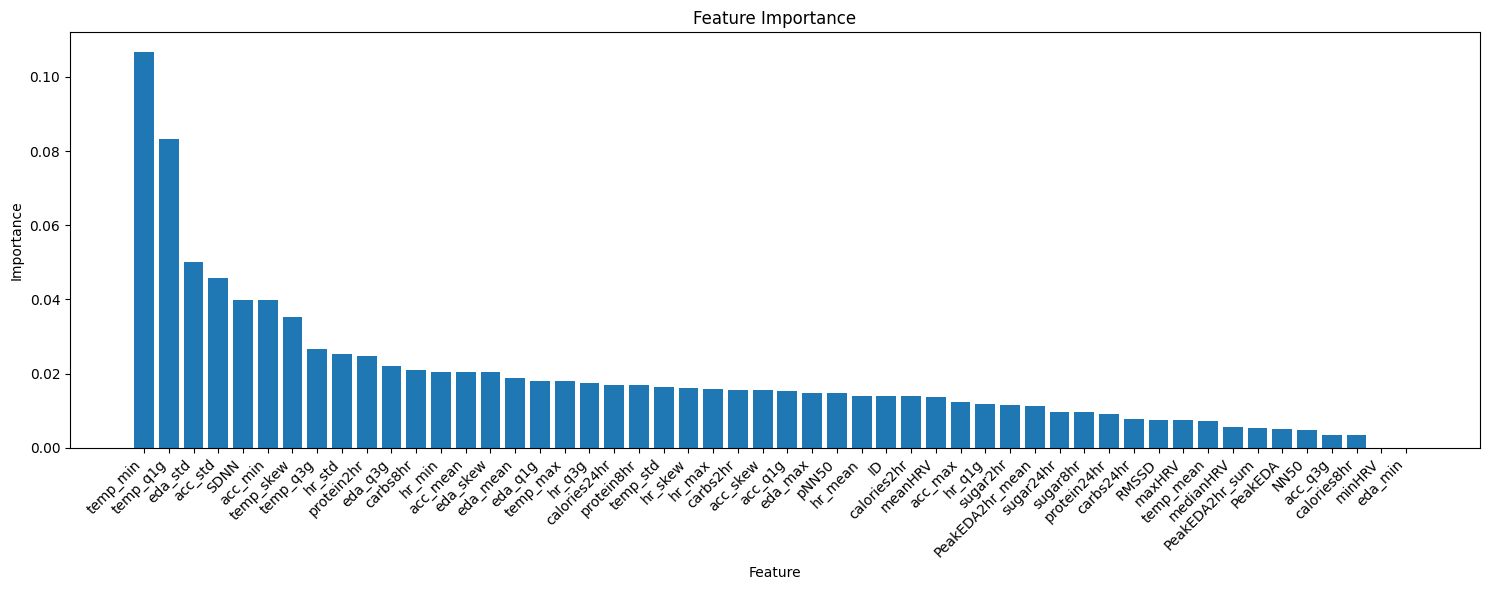

In [56]:
import matplotlib.pyplot as plt

# 막대그래프로 중요도 출력
plt.figure(figsize=(15, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')  # x축 라벨을 45도로 회전하여 가독성 높임
plt.tight_layout()  # 그래프 간격 조정
plt.show()

흠.. 이게 아닌데.. 24시간으로 잘라서 계산해야되나..으으으으으음.. 뭔가 수정이 필요함